In [2]:
import os
import time
import numpy as np
from net import *
# from loss import *
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES']='0'

In [3]:
import glob
# X = glob.glob('/data4/PCT/Journal_MAR/pj_metals/*.mat')
X = glob.glob('/data4/PCT/Journal_MAR/pj_metals/*.mat')
from sklearn.cross_validation import train_test_split
X_train, X_val, _, _ = train_test_split(X, X, test_size=0.3, random_state=42)

/home/pengchengtao/pct/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/pengchengtao/pct/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
from skimage import transform
import cv2
class SinogramDataset(Dataset):
    def __init__(self, file_path_list, phase='train'):
        self.path_list = file_path_list
        self.phase = phase
    
    def __getitem__(self, index):
        
        Sinogram_target1,Sinogram_target2, Image_target,mask,mask1= self.load_data(self.path_list[index])
        
        return Sinogram_target1,Sinogram_target2, Image_target,mask,mask1
    
    def load_data(self, file_path):
        metal_sinogram = sio.loadmat(file_path)['pj_metal']
#         metal_sinogram = sio.loadmat(file_path, verify_compressed_data_integrity=False)['Crop_metal']
        group_num=file_path.split('/')[-1].split('_')[0]
        slice_num=file_path.split('/')[-1].split('_')[1]
        Sinogram_target1 = sio.loadmat(os.path.join('/data4/PCT/Journal_MAR/pj_GroundTruth/','{}_{}_GroundTruth.mat'.format(group_num,slice_num)))['pj_GroundTruth']
        Image_target = np.load(os.path.join('/data4/PCT/Journal_MAR/Image_GroundTruth/','{}_{}_GroundTruth.npy'.format(group_num,slice_num)))
#         Sinogram_LI = sio.loadmat(os.path.join('/data4/PCT/Journal_MAR/LI_Sinograms/','_'.join(file_path.split('/')[-1].split('_')[0:3])+'_LISinograms.mat'))['Sinogram_LI']
#         Image_LI = sio.loadmat(os.path.join('/data4/PCT/Journal_MAR/LI_Images/','_'.join(file_path.split('/')[-1].split('_')[0:3])+'_LIImages.mat'))['Image_LI']
        mask = metal_sinogram == 0
        mask1 = mask
        Sinogram_target2 = Sinogram_target1
        Sinogram_target1,mask= self.process_data(Sinogram_target1,mask)
#         Image_target = Image_target.astype(np.float32)[np.newaxis,:,:]
#         Sinogram_target = Sinogram_target[np.newaxis,:,:]
#         Sinogram_LI = Sinogram_LI.astype(np.float32)[np.newaxis,:,:]
#         Image_LI = Image_LI.astype(np.float32)[np.newaxis,:,:]
#         mask = mask.astype(np.float32)[np.newaxis,:,:]
#         prior_image = prior_image[np.newaxis,:,:]
#         Image_LI = Image_LI.astype(np.float32)[np.newaxis,:,:]
        mask1 = mask1.astype(np.float32)[np.newaxis,:,:]
        Image_target = Image_target.astype(np.float32)[np.newaxis,:,:]
        Sinogram_target2 = Sinogram_target2.astype(np.float32)[np.newaxis,:,:]
        return Sinogram_target1,Sinogram_target2, Image_target,mask,mask1
        
    def process_data(self, *args):
        return [item[np.newaxis, :, 176:-176].astype(np.float32) for item in args]
#         return [item[np.newaxis, :, :].astype(np.float32) for item in args]
    
    def __len__(self):
        return len(self.path_list)

/home/pengchengtao/pct/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
batch_size = 4
num_workers = 4

trainset = SinogramDataset(file_path_list=X_train, phase='train')
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

valset = SinogramDataset(file_path_list=X_val, phase='train')
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [7]:
torch.backends.cudnn.benchmark = True
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')

In [8]:
from fan_fbp import *
from fan_projection.modules.fan_projection import FanProj

class CombineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.inpainting_model =  PConvUNet1()()
        self.ImageDomainNetwork = Unet()
        self.bottleneck = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),nn.ReLU(True),
                                             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),nn.ReLU(True),
                                             nn.Conv2d(64, 1, kernel_size=1))
    
    def forward(self, Sinogram_LI, Sinogram_target1,Sinogram_target2,mask,mask1):
        
        out_I1 = self.inpainting_model(Sinogram_LI)
        out_I2 = Sinogram_target1 * mask + out_I1 * (1 - mask)
        out_intact = Sinogram_target2
        out_intact[:,:,:,176:-176] = out_I2
        Processed_Image = self.ImageDomainNetwork(FanFBP(512, 512)(out_intact))
        output_I3 = FanProj(720, 1024)(Processed_Image)
        output_I3 = output_I3[:,:,:,176:-176]
        output_I4 = self.bottleneck(Sinogram_target1 * mask + output_I3 * (1 - mask))
        
        return out_I2, Processed_Image, output_I4

In [1]:
device_ids = [0,1,2,3]

model = CombineModel().to(device)

# Dis= DiscriminativeNet()
# checkpoint1 = torch.load('/data4/PCT/Artifact_Reducaion/CBCT dataset/models_CGAN_with_prior_image/CGAN_final_dis/checkpoint_497.pth.tar', map_location="cuda:0")
# Dis.load_state_dict(checkpoint1['state_dict'])
# Dis.cuda(device_ids[0])

# # Gen = FusionGenPeceptual().cuda(device_ids[0])
# # # Gen = GenerativeNet().cuda(device_ids[0])
# # Dis = DiscriminativeNet().cuda(device_ids[0])
model = nn.DataParallel(model, device_ids=device_ids)
# Dis = nn.DataParallel(Dis, device_ids=device_ids)
print(model)

NameError: name 'CombineModel' is not defined

In [9]:
from torch.optim.lr_scheduler import MultiStepLR
# if False:
#     lr = 5e-5
#     model.freeze_enc_bn = True
# optimizer_Gen = torch.optim.Adam(filter(lambda p: p.requires_grad, Gen.parameters()), lr=5e-4)
# optimizer_Gen = nn.DataParallel(optimizer_Gen, device_ids=device_ids)
# scheduler_Gen = MultiStepLR(optimizer_Gen.module, milestones=[150,300], gamma=0.3)

# criterion_Dis = nn.MSELoss().to(device)
# optimizer_Dis = torch.optim.Adam(Dis.parameters(),lr=1e-4)
# optimizer_Dis = nn.DataParallel(optimizer_Dis, device_ids=device_ids)
# scheduler_Dis = MultiStepLR(optimizer_Dis.module, milestones=[150,300], gamma=0.3)
criterion_1 = nn.L1Loss().to(device)
criterion_2 = InpaintingLoss().to(device)#Inpainting areas
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
# scheduler = MultiStepLR(optimizer.module, milestones=[50,120,240,360,540], gamma=0.3)
# scheduler = MultiStepLR(optimizer.module, milestones=[50,150,220,350], gamma=0.5)

/home/pengchengtao/pct/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [10]:
def save_checkpoint(state, checkpoint='checkpoint', snapshot=1):
    if not os.path.exists(checkpoint): os.makedirs(checkpoint)
    if snapshot and state['epoch'] % snapshot == 0:
        torch.save(state, os.path.join(checkpoint, 'checkpoint_{}.pth.tar'.format(state['epoch'])))
        

In [2]:
import scipy.io as sio
step=0
epoches=500

for epoch in range(1,epoches):
    loss_train_=0.0
    loss_val_=0.0
    num=0
    print('epoch:' + str(epoch))
#     scheduler.step()
    for i,data in enumerate(train_loader):
        num=num+1
        Sinogram_target1,Sinogram_target2, Image_target,mask,mask1= [item for item in data]
        Sinogram_target1 = Sinogram_target1.to(device)
        Sinogram_target2 = Sinogram_target2.to(device)
        mask = mask.to(device)
        mask1 = mask1.to(device)
        Image_target = Image_target.to(device)
    #         new_x, out_2, residual_x, out4= model(Sinogram_target, mask)
        out_1,out_2,out_3= model(Sinogram_target1*mask,Sinogram_target1,Sinogram_target2,mask,mask1)
        loss = 0.3*criterion_1(out_1,Sinogram_target1)+0.3*criterion_1(out_2,Image_target)+criterion_1(out_3,Sinogram_target1)
        optimizer.module.zero_grad()
        loss.backward()
        optimizer.module.step()
        
        with torch.no_grad():
            model.eval()
            for i,data in enumerate(val_loader):
                Sinogram_target1,Sinogram_target2, Image_target,mask,mask1= [item for item in data]
                Sinogram_target1 = Sinogram_target1.to(device)
                Sinogram_target2 = Sinogram_target2.to(device)
                mask = mask.to(device)
                mask1 = mask1.to(device)
                Image_target = Image_target.to(device)
                out_1,out_2,out_3= model(Sinogram_target1*mask,Sinogram_target1,Sinogram_target2,mask,mask1)
                loss_val=0.3*criterion_1(out_1,Sinogram_target1)+0.3*criterion_1(out_2,Image_target)+criterion_1(out_3,Sinogram_target1)
        
        loss_train_ = loss_train_+loss
#         loss_val_=loss_val_+loss_val
        
    print('Train_loss:  {}'.format(loss_train_/float(num)))
    print('Val_loss:  {}'.format(loss_val/float(num)))
    save_checkpoint({
            'epoch': epoch,
            'state_dict': model.module.state_dict(),
            }, checkpoint='/data4/PCT/Journal_MAR/Partial_Network_models/', snapshot=1)


    

/home/pengchengtao/pct/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/pengchengtao/pct/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


epoch:1


NameError: name 'scheduler' is not defined

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['/data4/PCT/Journal_MAR/pj_metals/Group1_90_1metal_metal.mat']


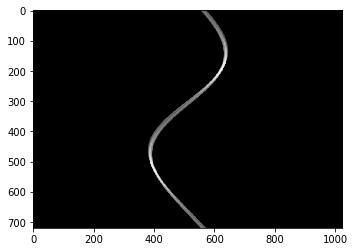

In [9]:
import scipy.io as sio
import matplotlib.pyplot as plt
file_path='/data4/PCT/Journal_MAR/pj_metals/Group1_90_1metal_metal.mat'
metal_sinogram=sio.loadmat(file_path)['pj_metal']
print(metal_sinogram)
plt.imshow(metal_sinogram,cmap='gray')
X_test=['/data4/PCT/Journal_MAR/pj_metals/Group1_90_1metal_metal.mat']
print(X_test)
valset = SinogramDataset(file_path_list=X_test, phase='val')
val_loader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=num_workers)

In [14]:
model = CombineModel().to(device)
model.eval()
checkpoint = torch.load('/data4/PCT/Journal_MAR/Partial_Network_models/checkpoint_{}.pth.tar'.format(300), map_location="cuda:0")#1173 65
model.load_state_dict(checkpoint['state_dict'])
for i, (data) in enumerate(val_loader, 0):
    Sinogram_target1,Sinogram_target2, Image_target,mask,mask1= [item for item in data]
    Sinogram_target1 = Sinogram_target1.to(device)
    Sinogram_target2 = Sinogram_target2.to(device)
    mask = mask.to(device)
    mask1 = mask1.to(device)
    Image_target = Image_target.to(device)
    out_1,out_2,out_3= model(Sinogram_target1*mask,Sinogram_target1,Sinogram_target2,mask,mask1)
target1 = Sinogram_target2.cpu().detach().numpy()[0,0,...]
out_1= out_1.cpu().detach().numpy()[0,0,...]
out_2= out_2.cpu().detach().numpy()[0,0,...]
out_3 = out_3.cpu().detach().numpy()[0,0,...]
result = target1
result[:,176:-176] = out_1
result=torch.from_numpy(result).float().to(device)
result=result[np.newaxis,np.newaxis,:,:]
from fan_fbp import *
AS_AIN=FanFBP(512, 512)(result)
AS_AIN=AS_AIN[0,0,:,:]
AS_AIN=AS_AIN.cpu().numpy()
# sio.savemat('/data4/PCT/Journal_MAR/Result_SF/AS_AIN.mat', {'AS_AIN':AS_AIN})
# sio.savemat('/data4/PCT/Journal_MAR/Result_SF/Partial_vertebra3_56_1metal.mat', {'Image_Partial':out_2})
sio.savemat('/data4/PCT/Journal_MAR/Result_SF/AS_P_tt_.mat', {'AS_P_':out_2})

/home/pengchengtao/pct/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [10]:
import numpy as np
import scipy.io as sio
Image_GT_vertebra2_29 = np.load('/data4/PCT/Journal_MAR/Image_GroundTruth/vertebra2_29_GroundTruth.npy')
sio.savemat('/data4/PCT/Journal_MAR/Result_SF/Image_GT_vertebra2_29.mat', {'GT_':Image_GT_vertebra2_29})